In [ ]:
#!pip install matplotlib torchinfo scikit-learn opencv-python

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import os
import cv2
from sklearn.model_selection import train_test_split
import random
import gc
import datetime
import sys

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Load in raw dataset, run pre-processing and convert to tensors.

In [3]:
#Data Pre-Processing -> Apply random contrast, saturation.  Flip horizontally once, then do 2 random rotations between -45 and 45 to flip and original (1 image becomes 6 images)

images_path = "archive/asl_alphabet_train/asl_alphabet_train"
image_folders = os.listdir(images_path)
#print(image_folders)

# Pre-allocate image_data
SKIP_VAL = 1 # reciprocal of what fraction of the dataset you want to use (1 is 100%, 2 is 50%, etc.)
NUM_CLASSES= 28
image_data= np.empty(((3000//SKIP_VAL)*NUM_CLASSES*6, 128, 128, 1), dtype=np.float16)
print("RAM used to store image data: " + str(sys.getsizeof(image_data) // (1024*1024)) + " MB")
labels = []
index = 0  # This will keep track of where you are in the array

for i in range(len(image_folders)):  # only use every five images from raw dataset
    gc.collect()
    print("Now loading in images from folder: " + str(image_folders[i]) + ", time: " + str(datetime.datetime.now().hour) + ":" + str(datetime.datetime.now().minute))
    
    # open up a folder corresponding to the hand gesture
    letter_folder_path = os.path.join(images_path, image_folders[i])
    folder_imgs = os.listdir(letter_folder_path)

    # open up each image in the subfolder and save data/labels
    for img in range(0, len(folder_imgs), SKIP_VAL):
        # read raw image
        image_path = os.path.join(letter_folder_path, folder_imgs[img])
        temp_data = cv2.imread(image_path)

        # resize to 128x128
        mod_img = cv2.resize(temp_data, (128, 128), cv2.INTER_LINEAR)
        
        # apply brightness and contrast, convert to grayscale
        brightness = random.randint(-50, 50)
        contrast = random.uniform(0.8, 1.2)
        mod_img = mod_img.astype(np.float32)  # convert to float32 for operations
        mod_img = cv2.addWeighted(mod_img, contrast, np.zeros(mod_img.shape, mod_img.dtype), 0, brightness)
        mod_img = cv2.cvtColor(mod_img, cv2.COLOR_BGR2GRAY)
        
        # apply and save Gaussian blur
        # mod_img = cv2.GaussianBlur(mod_img, (7, 7), 0)
        mod_img = mod_img[..., np.newaxis]  # adds a channel dimension
        
        # Assign the modified image to the pre-allocated array
        image_data[index] = mod_img.astype(np.float16)
        labels.append(np.float16(i)) #number corresponding to image folder currently open
        index += 1  # Increment the index for the next image
        
        # apply and save horizontal flip
        mod_img_flip = cv2.flip(mod_img, 1)
        mod_img_flip = mod_img_flip[..., np.newaxis]
        image_data[index] = mod_img_flip.astype(np.float16)
        labels.append(np.float16(i))
        index += 1
        
        # apply some random rotation (2 images for original and 2 for flipped) and save
        pos_rot = random.randint(5, 30)
        neg_rot = random.randint(-30, -5)
        (h, w) = mod_img.shape[:2]
        (ctrX, ctrY) = (h // 2, w // 2)
        pos_rot_mat = cv2.getRotationMatrix2D((ctrX, ctrY), pos_rot, 1.0)
        neg_rot_mat = cv2.getRotationMatrix2D((ctrX, ctrY), neg_rot, 1.0)
        
        orig_pos_rot_img = cv2.warpAffine(mod_img, pos_rot_mat, (w, h))
        orig_neg_rot_img = cv2.warpAffine(mod_img, neg_rot_mat, (w, h))
        flip_pos_rot_img = cv2.warpAffine(mod_img_flip, pos_rot_mat, (w, h))
        flip_neg_rot_img = cv2.warpAffine(mod_img_flip, neg_rot_mat, (w, h))
        
        # Assign the rotated images to the pre-allocated array
        orig_pos_rot_img = orig_pos_rot_img[..., np.newaxis]
        image_data[index] = orig_pos_rot_img.astype(np.float16)
        labels.append(np.float16(i))
        index += 1
        
        orig_neg_rot_img = orig_neg_rot_img[..., np.newaxis]
        image_data[index] = orig_neg_rot_img.astype(np.float16)
        labels.append(np.float16(i))
        index += 1
        
        flip_pos_rot_img = flip_pos_rot_img[..., np.newaxis]
        image_data[index] = flip_pos_rot_img.astype(np.float16)
        labels.append(np.float16(i))
        index += 1
        
        flip_neg_rot_img = flip_neg_rot_img[..., np.newaxis]
        image_data[index] = flip_neg_rot_img.astype(np.float16)
        labels.append(np.float16(i))
        index += 1
        
        del temp_data, mod_img, mod_img_flip, orig_neg_rot_img, orig_pos_rot_img, flip_neg_rot_img, flip_pos_rot_img

print(f"Length of image_data array: {len(image_data)}")
print(f"Length of labels list: {len(labels)}")
print("Total number of augmented images: " + str(NUM_CLASSES * 3000//SKIP_VAL * 6))

RAM used to store image data: 15750 MB
Now loading in images from folder: A, time: 20:24
Now loading in images from folder: B, time: 20:24
Now loading in images from folder: C, time: 20:25
Now loading in images from folder: D, time: 20:25
Now loading in images from folder: E, time: 20:26
Now loading in images from folder: F, time: 20:26
Now loading in images from folder: G, time: 20:27
Now loading in images from folder: H, time: 20:27
Now loading in images from folder: I, time: 20:28
Now loading in images from folder: J, time: 20:28
Now loading in images from folder: K, time: 20:29
Now loading in images from folder: L, time: 20:29
Now loading in images from folder: M, time: 20:29
Now loading in images from folder: N, time: 20:30
Now loading in images from folder: nothing, time: 20:30
Now loading in images from folder: O, time: 20:31
Now loading in images from folder: P, time: 20:31
Now loading in images from folder: Q, time: 20:32
Now loading in images from folder: R, time: 20:32
Now l

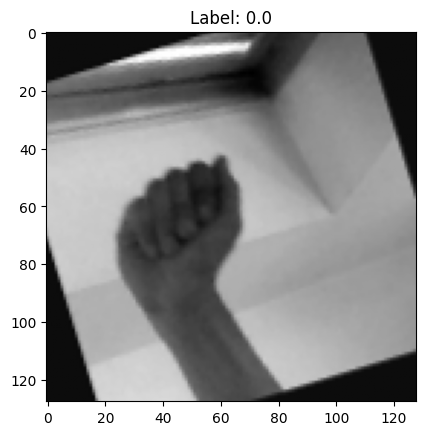

In [4]:
plt.imshow(image_data[2000].squeeze(), cmap='gray')
plt.title(f"Label: {labels[2000]}")
plt.show()

In [5]:
#ensure image data and labels are all float16
for i in range(len(image_data)):
    if image_data[i].dtype != "float16":
        print(image_data[i].dtype, i)

for i in range(len(labels)):
    if labels[i].dtype != "float16":
        print(labels[i].dtype, i)

#PyTorch requires color channels to be swapped for the image data
image_data = np.transpose(image_data, (0, 3, 1, 2))
print(image_data.shape)

#check the number of each label that was imported to make sure it is even
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

(504000, 1, 128, 128)


{np.float16(0.0): np.int64(18000),
 np.float16(1.0): np.int64(18000),
 np.float16(2.0): np.int64(18000),
 np.float16(3.0): np.int64(18000),
 np.float16(4.0): np.int64(18000),
 np.float16(5.0): np.int64(18000),
 np.float16(6.0): np.int64(18000),
 np.float16(7.0): np.int64(18000),
 np.float16(8.0): np.int64(18000),
 np.float16(9.0): np.int64(18000),
 np.float16(10.0): np.int64(18000),
 np.float16(11.0): np.int64(18000),
 np.float16(12.0): np.int64(18000),
 np.float16(13.0): np.int64(18000),
 np.float16(14.0): np.int64(18000),
 np.float16(15.0): np.int64(18000),
 np.float16(16.0): np.int64(18000),
 np.float16(17.0): np.int64(18000),
 np.float16(18.0): np.int64(18000),
 np.float16(19.0): np.int64(18000),
 np.float16(20.0): np.int64(18000),
 np.float16(21.0): np.int64(18000),
 np.float16(22.0): np.int64(18000),
 np.float16(23.0): np.int64(18000),
 np.float16(24.0): np.int64(18000),
 np.float16(25.0): np.int64(18000),
 np.float16(26.0): np.int64(18000),
 np.float16(27.0): np.int64(18000)}

In [6]:
#convert image_data and labels to tensors
image_data_tens = []

for i in image_data:
  t = torch.from_numpy(i)
  image_data_tens.append(t)

#Loop to transform numpy data to tensor
label_tens = []

for i in labels:
  t = torch.from_numpy(np.array(i))
  label_tens.append(t)

print(type(label_tens[1]))
print(type(image_data_tens[0]))

del image_data #can delete this now that we have tensors, but need to keep labels for reference in calculating accuracy

<class 'torch.Tensor'>
<class 'torch.Tensor'>


# Actual Model
Setup model hyperparameters

In [7]:
#Split dataset into training and test sets
x_Train, x_Test, y_Train, y_Test = train_test_split(image_data_tens, label_tens, random_state=42, shuffle=True, test_size=0.2)
unique, counts = np.unique(y_Train, return_counts=True)
print("train data contains: " + str(dict(zip(unique, counts))))
unique, counts = np.unique(y_Test, return_counts=True)
print("test data contains: "+ str(dict(zip(unique, counts))))
print("Train set samples: "+ str(len(y_Train)))
print("Test set samples: "+ str(len(y_Test)))

train_data = list(zip(x_Train, y_Train))
test_data = list(zip(x_Test, y_Test))

train data contains: {np.float16(0.0): np.int64(14429), np.float16(1.0): np.int64(14434), np.float16(2.0): np.int64(14340), np.float16(3.0): np.int64(14453), np.float16(4.0): np.int64(14336), np.float16(5.0): np.int64(14419), np.float16(6.0): np.int64(14406), np.float16(7.0): np.int64(14385), np.float16(8.0): np.int64(14370), np.float16(9.0): np.int64(14326), np.float16(10.0): np.int64(14420), np.float16(11.0): np.int64(14335), np.float16(12.0): np.int64(14455), np.float16(13.0): np.int64(14322), np.float16(14.0): np.int64(14468), np.float16(15.0): np.int64(14462), np.float16(16.0): np.int64(14325), np.float16(17.0): np.int64(14440), np.float16(18.0): np.int64(14448), np.float16(19.0): np.int64(14512), np.float16(20.0): np.int64(14415), np.float16(21.0): np.int64(14371), np.float16(22.0): np.int64(14424), np.float16(23.0): np.int64(14393), np.float16(24.0): np.int64(14453), np.float16(25.0): np.int64(14379), np.float16(26.0): np.int64(14287), np.float16(27.0): np.int64(14393)}
test dat

In [8]:
del image_data_tens, label_tens

In [9]:
n_epochs = 60
train_batch_size = 64
test_batch_size = 32
learning_rate = 0.0001
pool_kernel_size = 2

Load data into DataLoader objects for training/test

In [10]:
# Create a sampler for train and test data
train_sampler = torch.randperm(len(train_data))
test_sampler = torch.randperm(len(test_data))

# Convert the output of torch.randperm to a CPU tensor (needs to be CPU for this)
train_sampler = train_sampler.cpu()
test_sampler = test_sampler.cpu()

if device == "cpu":
    workers = 4
else: #gpu
    workers = 16

workers = 0 # degugging purposes

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size = train_batch_size, shuffle=False, sampler=train_sampler, num_workers = workers, pin_memory=True) # set shuffle to False to use the sampler

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size = test_batch_size, shuffle=False, sampler=test_sampler, num_workers = workers, pin_memory=True)

Setup the model layers

In [ ]:
class LSTM(nn.Module):

  #__init__: Construct the layers in the model
  def __init__(self):
    super(LSTM, self).__init__()

    # Flatten layer
    self.flatten = nn.Flatten()

    # Fully connected layers
    self.lstm_size = 256
    self.input_size = 128
    self.fc1 = nn.Linear(self.lstm_size * self.input_size, 64) #this could also be changed to a flattened size of just self.lstm_size for the last time step
    self.out = nn.Linear(64, 28)

    #LSTM layer
    self.lstm = nn.LSTM(input_size = self.input_size, hidden_size = self.lstm_size, num_layers=4, batch_first=True) #number of layers is the number of LSTM layers in sequences

    # Activation function layer
    self.relu = nn.ReLU()

    # Dropout layers
    self.fc_drop = nn.Dropout(p = 0.4)
    self.lstm_drop = nn.Dropout(p = 0.2)

    # Batch normalization layers (need unique ones for each size of layer)
    self.fc1_bn = nn.BatchNorm1d(64, affine=False)
    self.lstm_bn = nn.BatchNorm1d(self.lstm_size)

  # forward: setup the layer order (forward pass)
  def forward(self, x):
    #LSTM layers
    # I need this strange if check for different lengths becaues torchinfo uses different lengths (5) in its check than training actually uses (4)
    if len(x.shape) == 5:
        x = x.permute(0, 3, 4, 1, 2)
        batch_size, height, width, _, _ = x.size()
    elif len(x.shape) == 4:
        x = x.permute(0, 2, 3, 1)
        batch_size, height, width, _ = x.size()
    x = x.reshape(batch_size, width, height) #width is my time axis, so it used as my input length

    #apply LSTM layer and dropout/batch normalization
    x, (h_n, c_n) = self.lstm(x) #output, final hidden state, final cell state
    x = self.lstm_drop(x)
    x = x.transpose(1, 2) #reshape vector to get at hidden state
    x = self.lstm_bn(x) #batch normalize the hidden state

    #apply FC layers
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc1_bn(x)
    x = self.fc_drop(x)
    x = self.relu(x)
    x = self.out(x)
    
    return x


In [ ]:
#Instantiate a CNN model consructed above
lstm_model = LSTM()

#View summary of model (with full forward defined structure) and see all parameters
print(summary(lstm_model, input_size=(1, 1, 128, 128), batch_dim=0, device=device))
print(next(lstm_model.parameters()).device)
print(next(lstm_model.parameters()).dtype)

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [1, 29]                   --
├─LSTM: 1-1                              [1, 128, 256]             921,600
├─Dropout: 1-2                           [1, 128, 256]             --
├─BatchNorm1d: 1-3                       [1, 256, 128]             512
├─Flatten: 1-4                           [1, 32768]                --
├─Linear: 1-5                            [1, 64]                   2,097,216
├─BatchNorm1d: 1-6                       [1, 64]                   --
├─Dropout: 1-7                           [1, 64]                   --
├─ReLU: 1-8                              [1, 64]                   --
├─Linear: 1-9                            [1, 29]                   1,885
Total params: 3,021,213
Trainable params: 3,021,213
Non-trainable params: 0
Total mult-adds (M): 120.06
Input size (MB): 0.07
Forward/backward pass size (MB): 0.53
Params size (MB): 12.08
Estimated Total Size 

Train the model, evaluate on test set and save metrics

In [ ]:
#Define the loss function and optimizer
#should try an adjustable loss function eventually
lstm_model = lstm_model.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.2, min_lr = 0.00001)

In [17]:
def getClassAccuracy(preds, labels):
    preds = np.array(preds)
    labels = np.array(labels)
    classes = np.unique(np.array(labels, dtype=int)) #make keys ints 
    class_accuracies = {}

    for c in classes:
        indicies = np.where(labels == c)[0]  #Get indices where label == c
        correct = np.sum(preds[indicies] == labels[indicies])
        total = len(indicies)
        class_accuracies[c] = (correct / total) if total > 0 else 0.0  # Avoid division by zero

    return class_accuracies

def averageAccuracy(preds, labels):
    preds = np.array(preds)
    labels = np.array(labels)
    
    correct = np.sum(preds[:] == labels[:])
    total = len(preds)
    accuracy = (correct / total) if total > 0 else 0.0
    return accuracy

def classF1Score(preds, labels):
    score_array = sklearn.metrics.f1_score(labels, preds, average=None) 
    ave_f1_score = np.mean(score_array)  
    class_max = np.argmax(score_array)  
    class_min = np.argmin(score_array)  
    best_class_f1_score = np.max(score_array)
    worst_class_f1_score = np.min(score_array)
    
    return ave_f1_score, class_max, best_class_f1_score, class_min, worst_class_f1_score, score_array

In [18]:
test_loss = []
test_accuracy = []
test_f1_score = []
max_acc_class = []
best_class_acc = []
min_acc_class = []
worst_class_acc = []
max_f1_class = []
best_class_f1 = []
min_f1_class = []
worst_class_f1 = []
last_class_f1_score_array = []
last_class_accuracy_array = []

def test(model):
    loss = 0
    #put the model into eval mode to disable grads and learning
    model.eval()
    with torch.no_grad():
        n_correct = 0
        # n_total_samples = len(test_loader.dataset)
        all_predictions = []
        all_labels = []
        #Loop for testing image predictions vs labels
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).long()  # Convert labels to long (int64) for CrossEntropyLoss
            outputs = model(images.float())
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            preds = torch.argmax(probs, dim=1)  # Get predicted class labels
            loss += loss_f(outputs, labels)
            n_correct += (preds == labels).sum().item()
            all_predictions.append(preds.tolist())
            all_labels.append(labels.tolist())
        
        #flatten lists to be just one list so we can get accuracy metrics
        all_predictions = [item for sublist in all_predictions for item in sublist]
        all_labels = [item for sublist in all_labels for item in sublist]
        #calculate and store metrics
        # loss = loss_f(outputs, labels)
        loss /= len(test_loader)  # Average loss over the dataset
        test_loss.append(loss.item())
        class_accuracies = getClassAccuracy(np.array(all_predictions), np.array(all_labels))
        last_class_accuracy_array.append(class_accuracies)
        best_class = max(class_accuracies, key=class_accuracies.get)
        worst_class = min(class_accuracies, key=class_accuracies.get)
        max_acc_class.append(best_class)
        best_class_acc.append(class_accuracies[best_class])
        min_acc_class.append(worst_class)
        worst_class_acc.append(class_accuracies[worst_class])
        ave_accuracy = averageAccuracy(np.array(all_predictions), np.array(all_labels))
        test_accuracy.append(ave_accuracy)
        ave_f1_score, f1_class_max, best_class_f1_score, f1_class_min, worst_class_f1_score, score_array = classF1Score(np.array(all_predictions), np.array(all_labels))
        last_class_f1_score_array.append(score_array)
        test_f1_score.append(ave_f1_score)
        max_f1_class.append(f1_class_max)
        best_class_f1.append(best_class_f1_score)
        min_f1_class.append(f1_class_min)
        worst_class_f1.append(worst_class_f1_score)
        print(f"Test loss: {test_loss[-1]}") 
        print(f"Test average accuracy: {test_accuracy[-1]:.4f}, Max accuracy class: {max_acc_class[-1]} with {best_class_acc[-1]:.2f}, Min accuracy class: {min_acc_class[-1]} with {worst_class_acc[-1]:.2f}")
        print(f"Test average F1 score: {test_f1_score[-1]:.4f}, Max f1 class: {max_f1_class[-1]} with {best_class_f1[-1]:.2f}, Min f1 class: {min_f1_class[-1]} with {worst_class_f1[-1]:.2f}")
    #put the model back in train mode
    model.train()


Train Model

In [ ]:
n_total_steps = len(train_loader)
training_loss = []
training_accuracy = []

# Loop iterates over the number of epochs specified
for epoch in range(n_epochs):
  lstm_model.train() 

  # Loop iterates over the training loader
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device).long()
    
    # Forward pass and loss calculation
    outputs = lstm_model(images.float())
    probs = torch.softmax(outputs, dim=1)  # Convert output logits to probabilities
    preds = torch.argmax(probs, dim=1)  # Get predicted class labels
    loss = loss_f(outputs, labels)

    # Backward path and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  training_loss.append(loss.item())
  train_acc = averageAccuracy(preds.cpu().numpy(), labels.cpu().numpy())
  training_accuracy.append(train_acc)
  test(lstm_model)  # run the test dataset each epoch iteration

  #change the learning rate if needed
  scheduler.step(test_loss[-1])

  print(f'Epoch [{epoch + 1}/{n_epochs}], Step [{i + 1}/{n_total_steps}], Loss: {loss.item():.4f}, Time: {datetime.datetime.now().hour}:{datetime.datetime.now().minute}')
  print(f'Training accuracy: {train_acc:.4f}')


Test loss: 1.3725818395614624
Test average accuracy: 0.5695, Max accuracy class: 15 with 0.93, Min accuracy class: 27 with 0.30
Test average F1 score: 0.5669, Max f1 class: 15 with 0.94, Min f1 class: 25 with 0.31
Epoch [1/10], Step [6525/6525], Loss: 1.7322, Time: 20:25
Training accuracy: 0.4062
Test loss: 1.0164828300476074
Test average accuracy: 0.6766, Max accuracy class: 15 with 0.98, Min accuracy class: 24 with 0.33
Test average F1 score: 0.6753, Max f1 class: 15 with 0.94, Min f1 class: 24 with 0.40
Epoch [2/10], Step [6525/6525], Loss: 1.5321, Time: 20:27
Training accuracy: 0.4688
Test loss: 0.7879533171653748
Test average accuracy: 0.7454, Max accuracy class: 15 with 0.98, Min accuracy class: 24 with 0.39
Test average F1 score: 0.7463, Max f1 class: 15 with 0.96, Min f1 class: 24 with 0.47
Epoch [3/10], Step [6525/6525], Loss: 1.0520, Time: 20:30
Training accuracy: 0.6406
Test loss: 0.6571659445762634
Test average accuracy: 0.7841, Max accuracy class: 15 with 0.99, Min accurac

Plot the metrics for evaluation

In [ ]:
test(lstm_model)

Test loss: 0.39848506450653076
Test average accuracy: 0.8683, Max accuracy class: 15 with 0.99, Min accuracy class: 24 with 0.60
Test average F1 score: 0.8685, Max f1 class: 15 with 0.99, Min f1 class: 24 with 0.66


In [21]:
print("===============================================")
print("TEST EVALUATION RESULTS")
print("===============================================")
print("Final Training Loss: " + str(training_loss[-1])) 
print("Overall Test Loss: " + str(test_loss[-1]))
print("Overall Test Accuracy: " + str(test_accuracy[-1]*100) + "%")
print("Macro F1 Score: " + str(test_f1_score[-1]))
print("===============================================")
print("CLASS PERFORMANCE BREAKDOWN")
print("===============================================")
print(f"Best performing class (accuracy): Class {max_acc_class[-1]} with {best_class_acc[-1]*100:2f}% accuracy")
print(f"Worst performing class (accuracy): Class {(min_acc_class[-1])} with {(worst_class_acc[-1]*100):2f}% accuracy")
print(f"Best performing class (F1): Class {(max_f1_class[-1])} with {(best_class_acc[-1]):2f} F1 score")
print(f"Worst performing class (F1): Class {(min_f1_class[-1])} with {(worst_class_acc[-1]):2f} F1 score")
print("===============================================")

TEST EVALUATION RESULTS
Final Training Loss: 0.6353939175605774
Overall Test Loss: 0.39848506450653076
Overall Test Accuracy: 86.83333333333333%
Macro F1 Score: 0.8685370614662961
CLASS PERFORMANCE BREAKDOWN
Best performing class (accuracy): Class 15 with 98.997709% accuracy
Worst performing class (accuracy): Class 24 with 60.165975% accuracy
Best performing class (F1): Class 15 with 0.989977 F1 score
Worst performing class (F1): Class 24 with 0.601660 F1 score


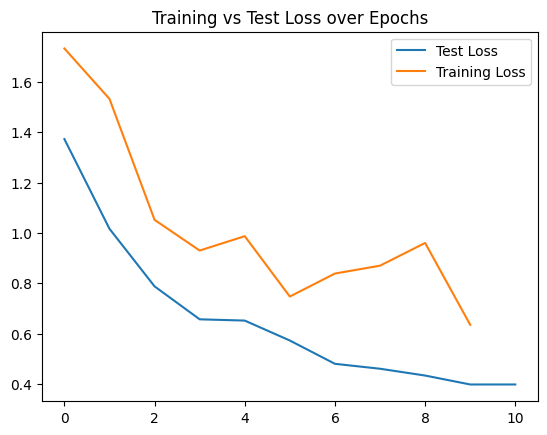

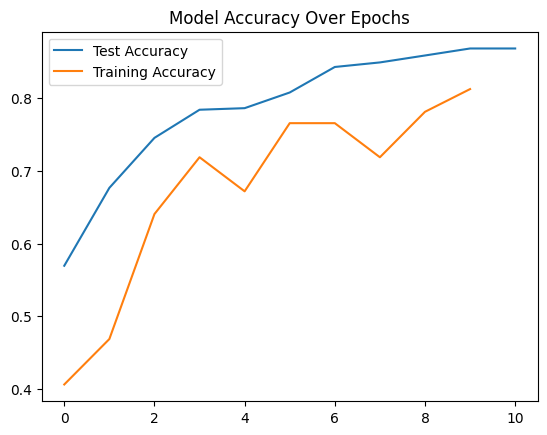

<Figure size 640x480 with 0 Axes>

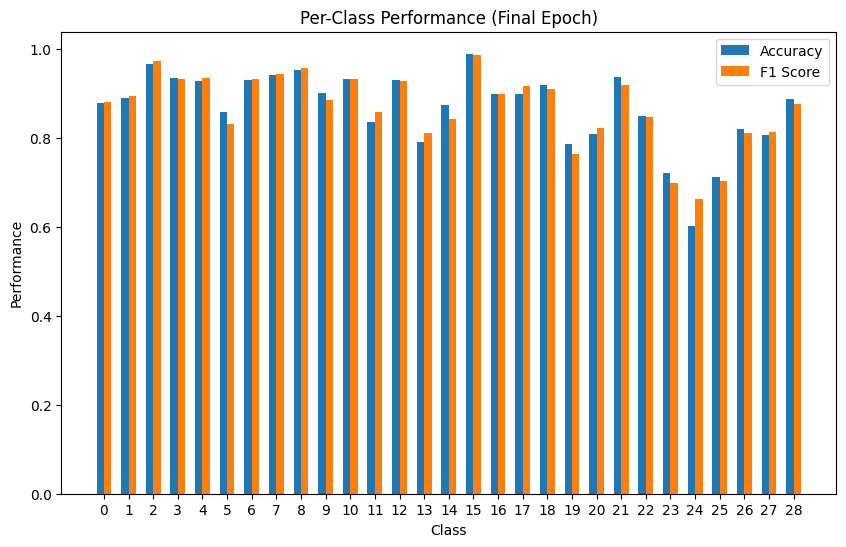

In [22]:
class_accuracy_data = list(last_class_accuracy_array[-1].values())
class_f1_data = last_class_f1_score_array[-1]

#get all labels from the dataset so I can pull unique values later
all_labels = []
for _, labels in train_loader:  
    all_labels.extend(labels.numpy())  
all_labels = np.array(all_labels)

current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

#make a loss plot
plt.figure()
plt.plot(test_loss, label="Test Loss")
plt.plot(training_loss, label="Training Loss")
plt.title("Training vs Test Loss over Epochs")
plt.legend()
plt.savefig(f"{current_time}-1.png")  # Save the plot
plt.show()

#make an accuracy plot
plt.figure()
plt.plot(test_accuracy, label="Test Accuracy")
plt.plot(training_accuracy, label="Training Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.legend()
plt.savefig(f"{current_time}-2.png")  # Save the plot
plt.show()

#Make a class performance plot
plt.figure()
x = np.arange(len(np.unique(all_labels))) * 5 # X locations for the groups
width = 1.5  # Width of the bars
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, class_accuracy_data, width, label='Accuracy')
ax.bar(x + width/2, class_f1_data, width, label='F1 Score')
# Labels, title, and legend
ax.set_xticks(x)
ax.set_xticklabels(np.unique(all_labels).astype(int))
ax.set_xlabel('Class')
ax.set_ylabel('Performance')
ax.set_title('Per-Class Performance (Final Epoch)')
ax.legend()
plt.savefig(f"{current_time}-3.png")  # Save the plot
plt.show()

In [ ]:
# Save model to .pth file
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
torch.save(lstm_model.state_dict(), f"lstm_{current_time}.pth")